## Classification Modeling: analyzing customer churn within Telco
### Goals

My main goal for this project is to construct a classification model that effectively predicts customer churn for Telco. I will be identifying which variables are the main drivers of churn, excluding contract type. 

I will be acquiring the data, cleaning and prepping it, give my predicitions and finally, my report and recommendations.

### Prepare Environment

In [1]:
# Overall Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pydataset import data

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Get and scrub the data
import acquire, prepare

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

# Save and load machine learning models
#import pickle, joblib

# Set plotting paras
plt.style.use('seaborn-talk')

### Data Acquisition

In [2]:
# Load dataset into pandas dataframe

df = acquire.get_telco_data()
print("Number of (rows, columns): ", df.shape)
df.head()

Number of (rows, columns):  (7043, 24)


,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


### Data Preparation

In [3]:
# Print the summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
# Replace the white space with 0 in column total_charges
df['total_charges'] = df.total_charges.apply(lambda i: "0" if i == " " else i)

In [5]:
# Correct the data types of column total_charges 

datatype = {'total_charges': 'float64'}
df = df.astype(dtype=datatype)

df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges               float64
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

In [6]:
# Calculate the number of missing values in each column
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [8]:
# Count distinct observations in each column
df.nunique()

payment_type_id                4
internet_service_type_id       3
contract_type_id               3
customer_id                 7043
gender                         2
senior_citizen                 2
partner                        2
dependents                     2
tenure                        73
phone_service                  2
multiple_lines                 3
online_security                3
online_backup                  3
device_protection              3
tech_support                   3
streaming_tv                   3
streaming_movies               3
paperless_billing              2
monthly_charges             1585
total_charges               6531
churn                          2
contract_type                  3
internet_service_type          3
payment_type                   4
dtype: int64

In [7]:
# Drop them duplicates
df = df.drop_duplicates()
df.shape

(7043, 24)

In [71]:
dummy_df = pd.get_dummies(df[['internet_service_type']], dummy_na=False, drop_first=[True, True])
dummy_df.head()


,internet_service_type
0,1
1,1
2,1
3,1
4,1


In [9]:
# Calculate descriptive statistics of the numeric columns in the dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.00,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.00,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.00,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


### Plot Distribution of Individual Variables

In [10]:
# Obtain the name of the variables

variables = df.columns
print(len(variables))
print(type(variables))
variables

24
<class 'pandas.core.indexes.base.Index'>


Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [11]:
# Obtain the name of the object columns

mask = (df.dtypes == 'object')
obj_cols = variables[mask].to_list()

# Manually correct the list
obj_cols.remove('customer_id')
obj_cols.append('senior_citizen')

print(len(obj_cols))
obj_cols

17


['gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'senior_citizen']

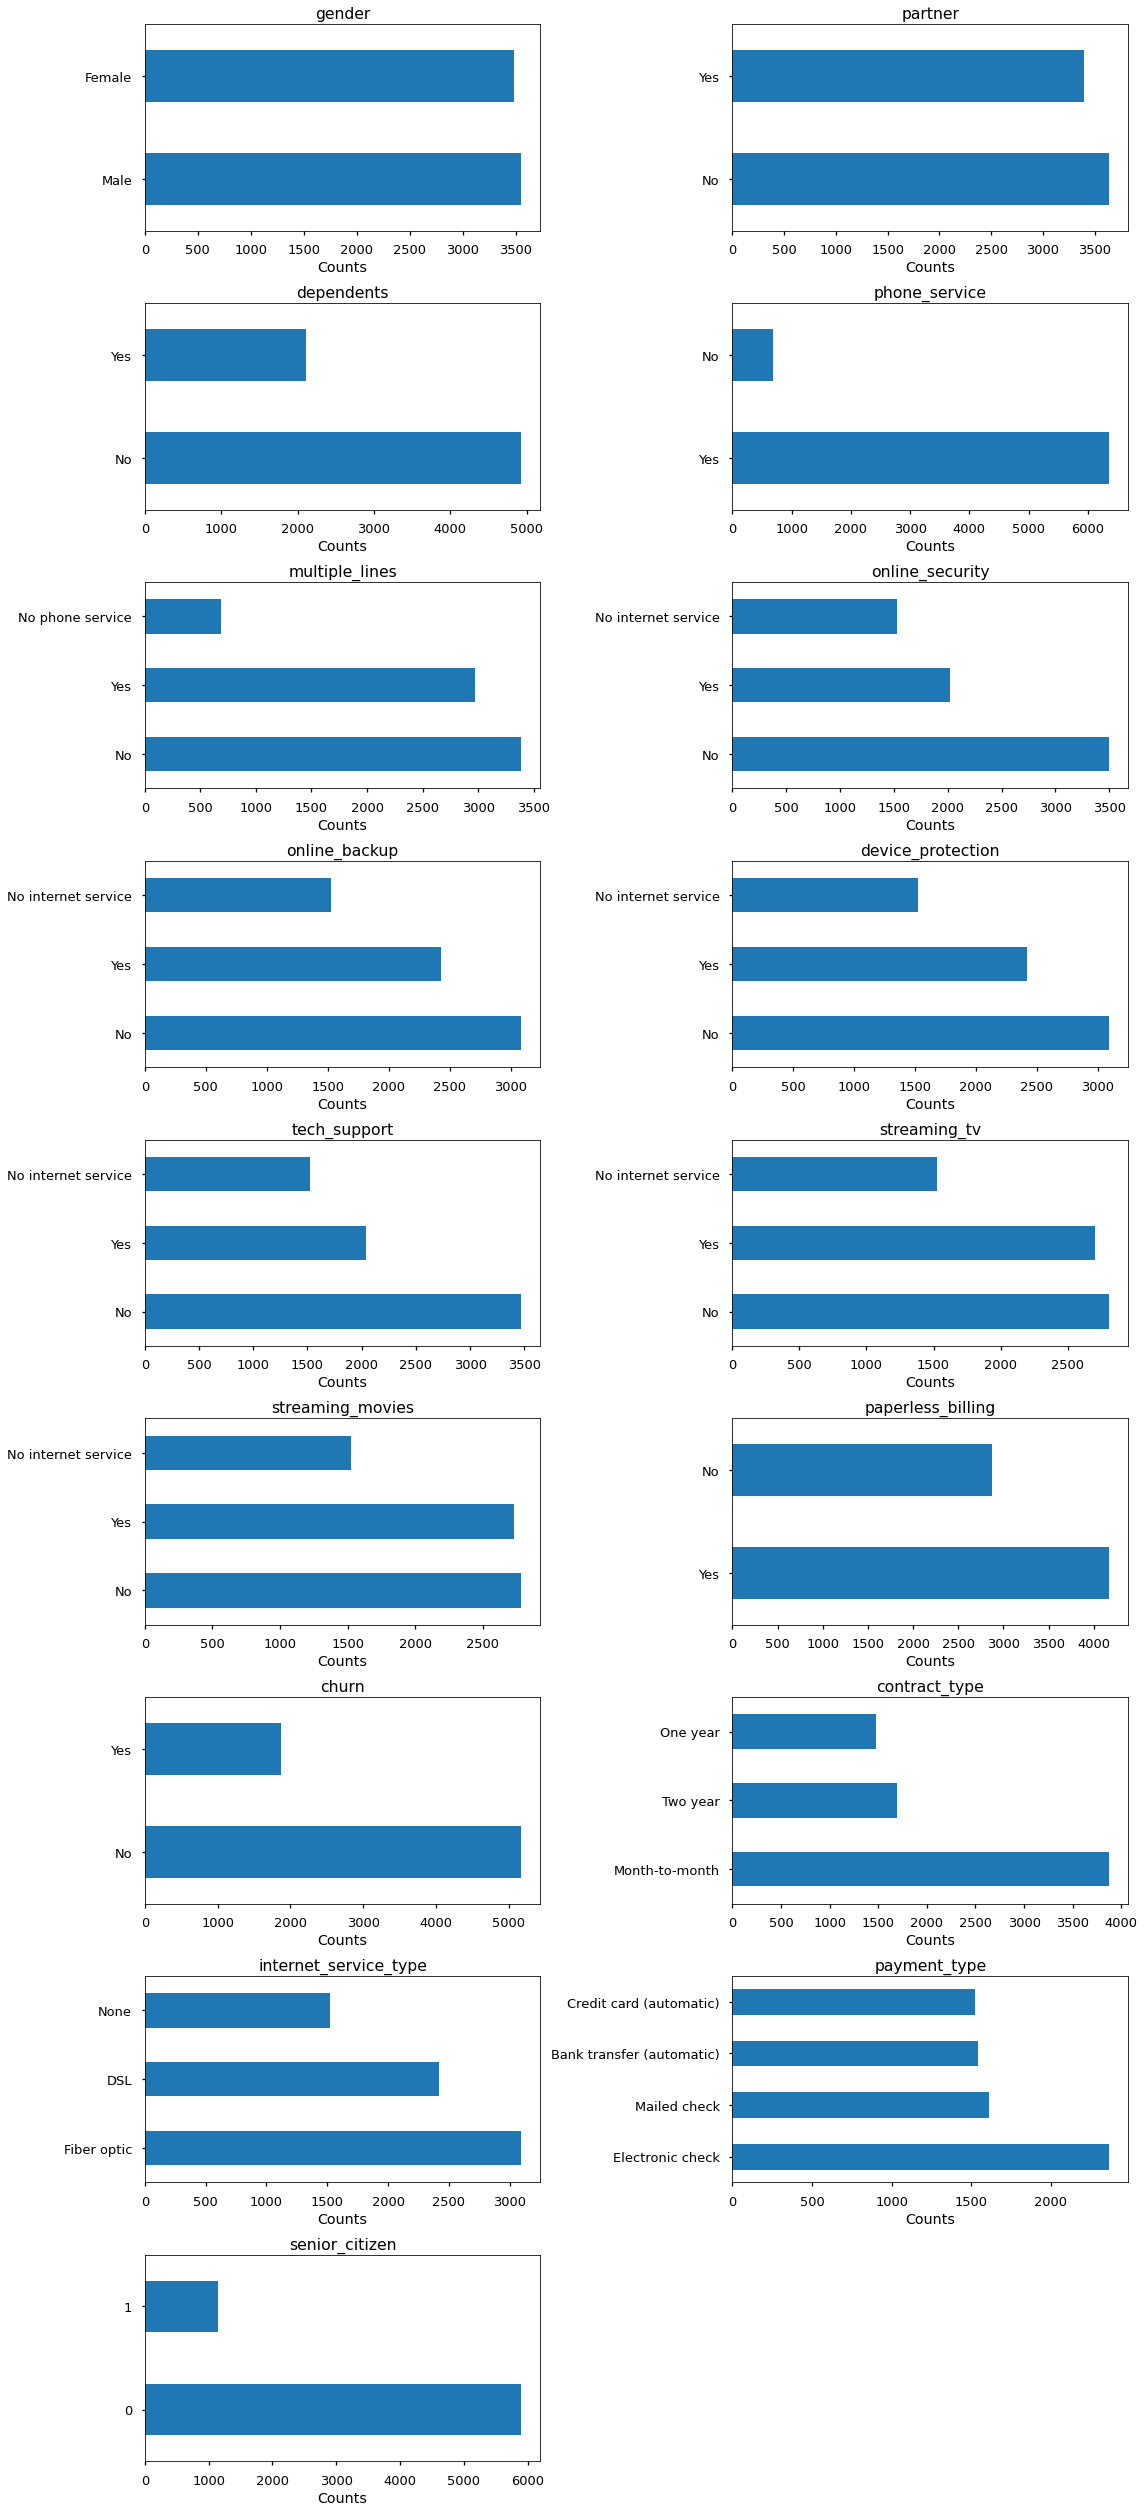

CPU times: user 1.55 s, sys: 43.8 ms, total: 1.59 s
Wall time: 726 ms


In [12]:
%%time
# Plot the histograms of each object column

plt.figure(figsize=(16,35))

number_cols = len(obj_cols)

for i, variable in zip(range(number_cols), obj_cols):
    plt.subplot(9,2,i+1)
    df[variable].value_counts().plot(kind='barh', title=f'{variable}')
    plt.xlabel('Counts')
    
plt.tight_layout()
plt.show()

In [13]:
# Obtain the name of the non-object columns

mask = (df.dtypes != 'object')
num_cols = variables[mask].to_list()

# Manually correct the list

num_cols.remove('payment_type_id')
num_cols.remove('internet_service_type_id')
num_cols.remove('contract_type_id')
num_cols.remove('senior_citizen')

print(len(num_cols))
num_cols

3


['tenure', 'monthly_charges', 'total_charges']

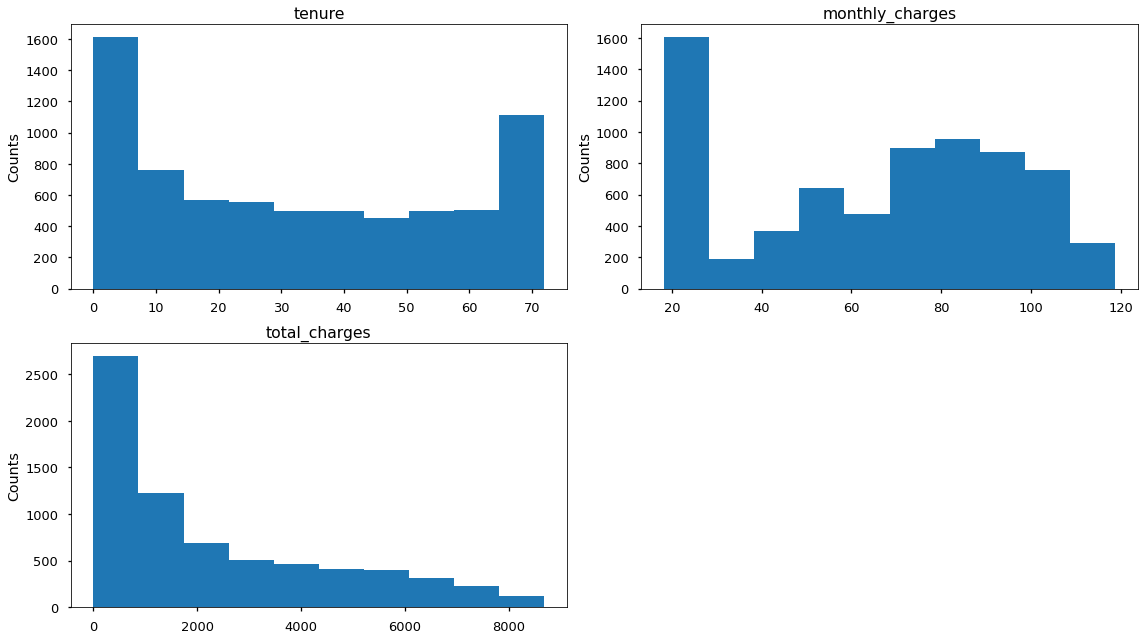

CPU times: user 491 ms, sys: 9.13 ms, total: 500 ms
Wall time: 187 ms


In [14]:
%%time
# Plot the histograms of each numeric column

plt.figure(figsize=(16,9))

number_cols = len(num_cols)

for i, variable in zip(range(number_cols), num_cols):
    plt.subplot(2,2,i+1)
    df[variable].plot(kind='hist', title=f'{variable}')
    plt.ylabel("Counts")
    
plt.tight_layout()
plt.show()

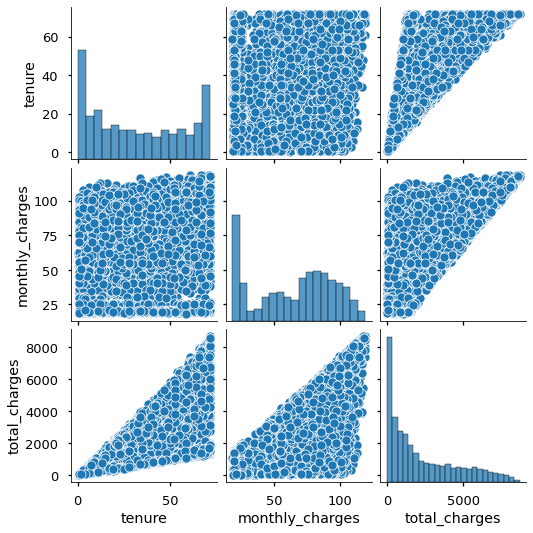

In [15]:
# Pairplot the numeric variables

sns.pairplot(df[num_cols])
plt.show()

In [16]:
%%time
# Prepare the data for exploration and modeling

train, validate, test = prepare.prep_telco_churn(df)
train.head()

CPU times: user 17.6 ms, sys: 2.31 ms, total: 19.9 ms
Wall time: 26.1 ms


,customer_id,senior_citizen,tenure,phone_service,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service,tenure_year,male
5310,7503-MIOGA,1,72,1,1,1,1,89.85,6697.35,0,2,1,1,1,1,1,6.0,0
3790,5329-KRDTM,1,72,1,1,1,0,77.35,5396.25,0,2,1,1,1,1,1,6.0,1
4398,6199-IWKGC,1,46,1,0,1,0,100.25,4753.85,0,1,1,0,1,1,0,3.8,0
2635,3748-FVMZZ,0,4,0,0,1,1,40.05,162.45,0,0,1,0,0,1,0,0.3,1
2986,4280-DLSHD,0,8,1,1,0,1,54.75,445.85,0,0,1,0,1,0,1,0.7,1


In [17]:
# Print a concise summary of train dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5310 to 6817
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        3943 non-null   object 
 1   senior_citizen     3943 non-null   int64  
 2   tenure             3943 non-null   int64  
 3   phone_service      3943 non-null   int64  
 4   device_protection  3943 non-null   int64  
 5   tech_support       3943 non-null   int64  
 6   paperless_billing  3943 non-null   int64  
 7   monthly_charges    3943 non-null   float64
 8   total_charges      3943 non-null   float64
 9   churn              3943 non-null   int64  
 10  contract_type      3943 non-null   int64  
 11  internet_service   3943 non-null   int64  
 12  payment_type       3943 non-null   int64  
 13  partner_dependent  3943 non-null   int64  
 14  streaming          3943 non-null   int64  
 15  online_service     3943 non-null   int64  
 16  tenure_year        39

In [18]:
# Print the shapes of the train, validate and test

train.shape, validate.shape, test.shape

((3943, 18), (1691, 18), (1409, 18))

### Data Exploration Stage
- Explore the target variable
- What is the churn rate?
- Conduct hypothesis tests

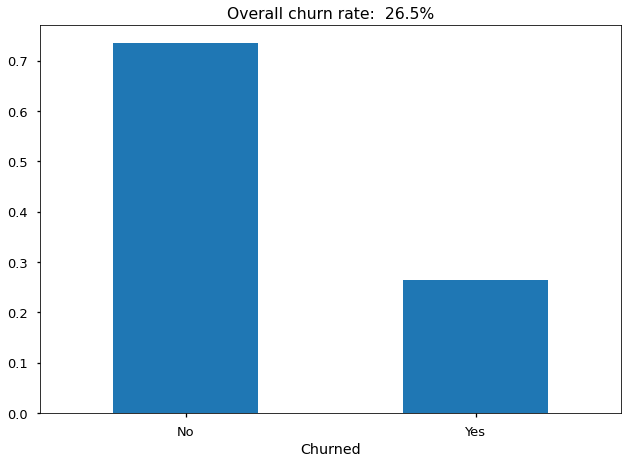

In [19]:
# Compute and visualize the overall churn rate

train.churn.value_counts(normalize=True).plot.bar()
churn_rate = train.churn.mean()
plt.title(f"Overall churn rate: {churn_rate: .1%}")
plt.xlabel('Churned')
plt.xticks([0,1], ['No', 'Yes'], rotation=0) # Set text labels and properties
plt.show()

### Is there a type of internet service that churns more than others?
Null Hypothesis: Customers who have fiber optics churn more.

Alternate Hypothesis: Customers with DSL and no internet churn more.

Alpha =0.05

In [20]:
# Create a list of all categorical features
categorical_vars = ['internet_service']

# For Loop through the list and perform the hypothesis test
for feature in categorical_vars:
    
    # Compute the contingency(frequency) table
    contingency_table = pd.crosstab(train.churn, train[feature])

    # Print the contingency table
#     print(contingency_table, '\n')

    # Perform chi2 test
    chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

    # Decide whether to reject/accept null hypothesis
    if p/2 < 0.25:
#         print(f'Reject Null Hypotheis, because {p/2: .2} < 0.25')
        print(f"Customer churn is dependent on {feature} feature.")
    elif p/2 > 0.25:
#         print(f'Accept Null Hypotheis, because {p/2: .2} > 0.25')
        print(f"Customer churn is independent of {feature} feature.")

Customer churn is dependent on internet_service feature.


In [21]:
# Create two datasets for churned customers and retained customers respectively

train_churned = train[train.churn == 1]
train_retained = train[train.churn == 0]

In [22]:
# Compute the variances 
train_churned.internet_service .var(), train_retained.internet_service.var()

# Perform 2 sample t-test
t, p = stats.ttest_ind(train_churned.internet_service,
                       train_retained.internet_service,
                       equal_var=False)
# print(t, p)

# Decide whether to reject or accept the null hypothesis

if p < 0.5:
    print('Reject Null Hypotheis')
else:
    print('Accept Null Hypotheis')

Reject Null Hypotheis


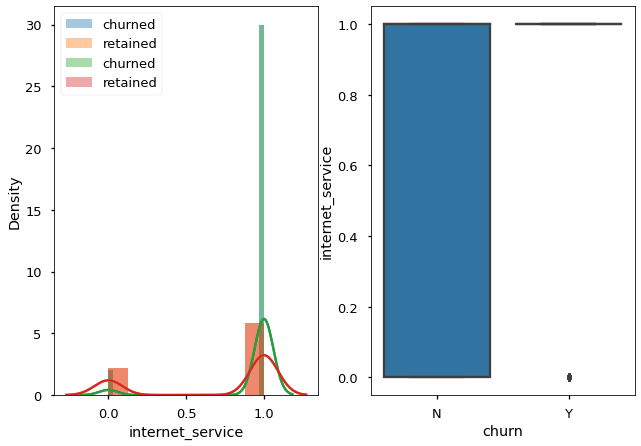

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


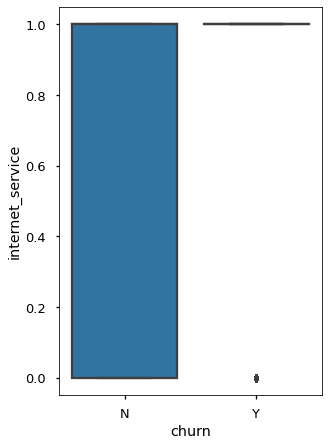

In [23]:
# Plot the distribution of the tenures in churned and retained customers

plt.subplot(121)

sns.distplot(train_churned.internet_service, label='churned')
sns.distplot(train_retained.internet_service, label='retained')
# Plot the distribution of the tenures in churned and retained customers

plt.subplot(121)

sns.distplot(train_churned.internet_service, label='churned')
sns.distplot(train_retained.internet_service, label='retained')

plt.legend()

# Draw the box plots to show the distribution
plt.subplot(122)

sns.boxplot(data=train, x='churn', y='internet_service')
plt.xticks([0,1], ['N','Y'])

plt.show()
plt.legend()

# Draw the box plots to show the distribution
plt.subplot(122)

sns.boxplot(data=train, x='churn', y='internet_service')
plt.xticks([0,1], ['N','Y'])

plt.show()

### Modeling and Evaluation
The algorithms to be tested will be:
- Logistic regression
- Decision tree
- Random forest
- KNN

Accuracy and recall will be used as the performance metrics, especially recall, because because it is better to send a retained customer for review than it is to miss out on an actually churned customer.

In [24]:
# Remove attributes that are either unrelated to the target variable or correlated to other attributes

X_train = train.drop(columns=['customer_id','churn','male','total_charges','tenure_year', 'senior_citizen', 'device_protection'])
X_validate = validate.drop(columns=['customer_id','churn','male', 'total_charges','tenure_year', 'senior_citizen', 'device_protection'])
X_test = test.drop(columns=['customer_id','churn','male','total_charges','tenure_year', 'senior_citizen', 'device_protection'])

# Create target variable

y_train = train['churn']
y_validate = validate['churn']
y_test = test['churn']

In [25]:
# Inspect the X_train
X_train.head()

,tenure,phone_service,tech_support,paperless_billing,monthly_charges,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service
5310,72,1,1,1,89.85,2,1,1,1,1,1
3790,72,1,1,0,77.35,2,1,1,1,1,1
4398,46,1,1,0,100.25,1,1,0,1,1,0
2635,4,0,1,1,40.05,0,1,0,0,1,0
2986,8,1,0,1,54.75,0,1,0,1,0,1


In [26]:
X_train.columns

Index(['tenure', 'phone_service', 'tech_support', 'paperless_billing',
       'monthly_charges', 'contract_type', 'internet_service', 'payment_type',
       'partner_dependent', 'streaming', 'online_service'],
      dtype='object')

### Baseline Model

In [27]:
# Compute the accuracy of the baseline model
y_train.value_counts(normalize=True)

0    0.73472
1    0.26528
Name: churn, dtype: float64

In [28]:
#model_accuracy = (df.prediction == df.actual).mean()
#baseline_accuracy = (df.baseline_prediction == df.actual).mean()

#print(f'   model accuracy: {model_accuracy:.2%}')
#print(f'baseline accuracy: {baseline_accuracy:.2%}')


### Logistic Regression

- the goal with this model is to find values for the coefficients that weight each input variable.
- the output is a value between 0 and 1 that represents the probability of one class over the other.
- Much like linear regression, logistic regression works best when you remove attributes that aren't related to the output variable, or attached to other attributes.

In [29]:
# Create the logistic regression object

logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')


# Fit the model to the training data
logit.fit(X_train, y_train)


LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

In [30]:
#Evaluate importance, or weight, of each feature, using the coefficients.

#Evaluate the intercept of the model.

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.02619663 -1.01019378 -0.39155821  0.35348096  0.03823768 -0.90891547
   0.12525003 -0.2291206  -0.18009441 -0.31466806 -0.4304039 ]]
Intercept: 
 [3.23948147]


In [31]:
# Estimate whether or not the species is versicolor for each observation, using the training data.
y_pred = logit.predict(X_train)

In [32]:
# Estimate the probability

y_pred_proba = logit.predict_proba(X_train)


In [33]:
# Compute the accuracy
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))


Accuracy of Logistic Regression classifier on training set: 0.32


In [34]:
# Create a confusion matrix
print(confusion_matrix(y_train, y_pred))

[[ 235 2662]
 [   1 1045]]


In [35]:
# Create a classification Report
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.08      0.15      2897
           1       0.28      1.00      0.44      1046

    accuracy                           0.32      3943
   macro avg       0.64      0.54      0.29      3943
weighted avg       0.81      0.32      0.23      3943



### Decision Trees
aka CART: Classification and Regression Trees
- We use the training data to train the tree to find a decision boundary to use as a decision rule for future data
- Sorta like playing 20 questions. Each question is a yes or a no. The number of questions is the depth of the tree.
- Give too much depth and you risk overfitting your model.

In [36]:
# Create the Deicsion Tree object
dt = DecisionTreeClassifier(max_depth=3, random_state=123)

In [37]:
# Fit the model
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [38]:
# Get the parameters of the model
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

In [39]:
# Print the Gini importances

importances = dt.feature_importances_
importances = pd.DataFrame(importances, index=X_train.columns, columns=['total_reduction'])
importances

,total_reduction
tenure,0.218841
phone_service,0.000000
tech_support,0.000000
paperless_billing,0.000000
monthly_charges,0.168075
contract_type,0.613084
internet_service,0.000000
payment_type,0.000000
partner_dependent,0.000000
streaming,0.000000


In [40]:
# Evaluate accuracy and recall using train dataset

train_acc = dt.score(X_train, y_train)
print(train_acc, "\n")

y_pred_train = dt.predict(X_train)
print(classification_report(y_train, y_pred_train), '\n')

# Print the confusion matrix
matrix = confusion_matrix(y_train, y_pred_train)
matrix

0.7851889424296221 

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      2897
           1       0.68      0.36      0.47      1046

    accuracy                           0.79      3943
   macro avg       0.74      0.65      0.67      3943
weighted avg       0.77      0.79      0.76      3943
 



array([[2715,  182],
       [ 665,  381]])

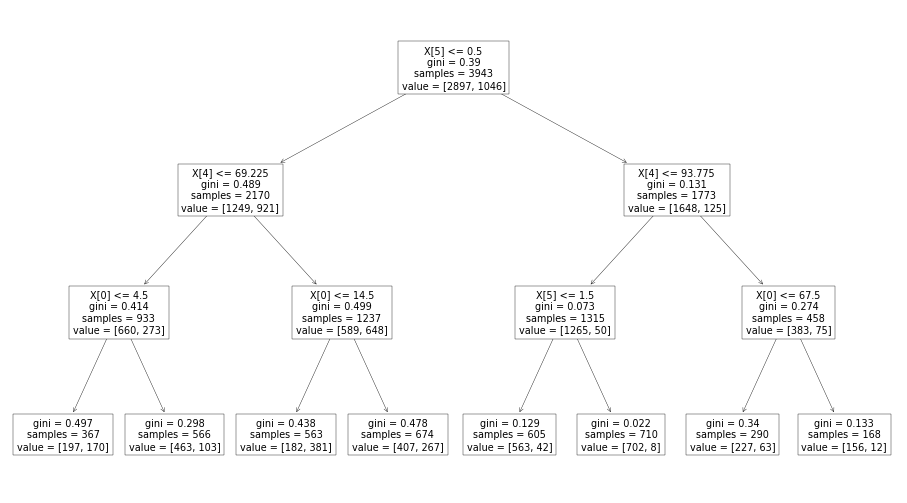

In [41]:
# Visualize the tree structure

plt.figure(figsize=(16,9))
plot_tree(dt)
plt.show()

### Random Forest 

- Random Forest is a type Ensemble Machine Learning algorithm called Bootstrap Aggregation or bagging.
- Bootstrapping is a statistical method for estimating a quantity from a data sample, e.g. mean. 
- Multiple samples of your training data are taken and models are constructed for each sample set. 
- Random forest is a tweak on this approach where decision trees are created so that rather than selecting optimal split points, suboptimal splits are made by introducing randomness.


In [42]:
# Create the random forest object

rf = RandomForestClassifier(n_estimators=100, 
                            max_depth=3, 
                            min_samples_split=2, 
                            min_samples_leaf=5, 
                            random_state=123)

In [43]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [44]:
# Evaluate importance

importances = rf.feature_importances_
importances = pd.DataFrame(importances, index=X_train.columns, columns=['total_reduction'])
importances

,total_reduction
tenure,0.272495
phone_service,0.002477
tech_support,0.034285
paperless_billing,0.032897
monthly_charges,0.116829
contract_type,0.328299
internet_service,0.090099
payment_type,0.066631
partner_dependent,0.015482
streaming,0.008633


In [45]:
# Make predictions

y_pred = rf.predict(X_train)

In [46]:
# Estimate Probability

y_pred_proba = rf.predict_proba(X_train)

In [47]:
# Compute the Accuracy

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.78


In [48]:
# Create a classfication report

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      2897
           1       0.73      0.29      0.42      1046

    accuracy                           0.78      3943
   macro avg       0.76      0.63      0.64      3943
weighted avg       0.78      0.78      0.75      3943



In [49]:
# Create a confusion matrix

print(confusion_matrix(y_train, y_pred))

[[2785  112]
 [ 738  308]]


In [50]:
# Evaluate on Out-of-Sample data

print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.78


### KNN

- Makes predictions based on how close a new data point is to known data points.
- Considered a lazy algorithm in that it does not attempt to construct a general internal model, but simply stores instances of the training data.
- Predictions are made for a new data point by searching through the entire training set for the K most similar instances (the neighbors) and summarizing the output variable for those K instances.
- For classification problems this might be the mode (or most common) class value.

In [51]:
# Create KNN Object

# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [52]:
# Fit the model

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [53]:
# Make predictions

y_pred = knn.predict(X_train)

In [54]:
# Estimate probability

y_pred_proba = knn.predict_proba(X_train)

In [55]:
# Compute accuracy of model

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.83


In [56]:
# Create a confusion matrix

print(confusion_matrix(y_train, y_pred))

[[2650  247]
 [ 413  633]]


In [57]:
# Create a classification report

print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2897
           1       0.72      0.61      0.66      1046

    accuracy                           0.83      3943
   macro avg       0.79      0.76      0.77      3943
weighted avg       0.83      0.83      0.83      3943



In [58]:
# Lets validate our model 

print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.76


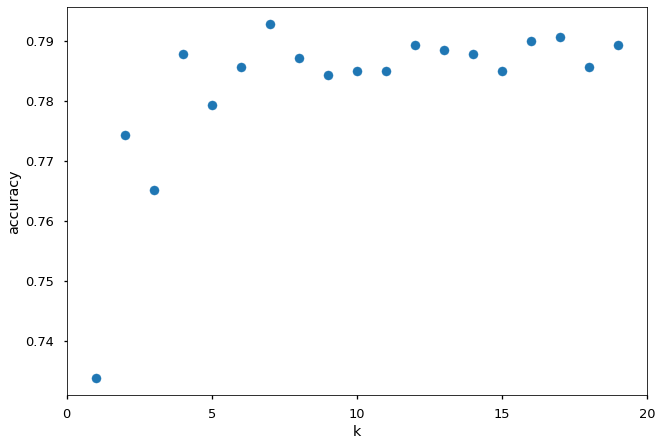

In [59]:
# Visualize model

import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

In [60]:
# Summary

# Create a list of names of the classifiers

names = ['LogisticRegression', 
         'Decision Tree',
         'Random Forest',
         'K-Nearest Neighbors'
        ]

# Create a list of classifiers

classifiers = [LogisticRegression(), 
               DecisionTreeClassifier(max_depth=3, random_state=123),
               RandomForestClassifier(max_depth=3, random_state=123),
               KNeighborsClassifier(5)
              ]

# Create a dataframe to hold the results
performance = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    
    clf = classifier.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    
    y_pred_validate = clf.predict(X_validate)
    validate_acc = accuracy_score(y_validate, y_pred_validate)
    validate_recall = recall_score(y_validate, y_pred_validate)
    
    d = {'model': name,
         'train_acc': train_acc, 'train_recall': train_recall,
         'validate_acc': validate_acc, 'validate_recall': validate_recall}
    
    performance = performance.append(d, ignore_index=True)
    
performance

,model,train_acc,train_recall,validate_acc,validate_recall
0,LogisticRegression,0.801167,0.526769,0.796570,0.512249
1,Decision Tree,0.785189,0.364245,0.785334,0.367483
2,Random Forest,0.784428,0.294455,0.777646,0.278396
3,K-Nearest Neighbors,0.832615,0.605163,0.761088,0.476615


### Takeaways

- Logistic Regression is selected to be the best model for further testing because both its accuracy and recall rank high and it doesn't appear to have an overfitting problem.
- The recalls of decision tree and random forest aren't good.
- KNN is not selected due to overfitting.

In [63]:

# Evaluate accuracy and recall using validate dataset

test_acc = logit.score(X_test, y_test)
print(test_acc, "\n")

y_pred_test = logit.predict(X_test)
print(classification_report(y_test, y_pred_test), '\n')

# Print the confusion matrix
matrix = confusion_matrix(y_test, y_pred_test)

matrix



0.32647267565649396 

              precision    recall  f1-score   support

           0       0.98      0.09      0.16      1035
           1       0.28      0.99      0.44       374

    accuracy                           0.33      1409
   macro avg       0.63      0.54      0.30      1409
weighted avg       0.79      0.33      0.23      1409
 



array([[ 88, 947],
       [  2, 372]])